In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('/Users/Device6/Documents/Research/bgoodlab/dNdS/dNdS_dynamics/')

from dNdS_analysis.utils import dynamics_utils, theory_utils
import dNdS_analysis.config as config

In [2]:
full_dnds_df = dynamics_utils.load_dNdS_data()

In [3]:
full_dnds_df.head()

core_diff core_len  \
species_name                 sample 1  sample 2                       
Bacteroides_finegoldii_57739 700016960 700021123       511  2059341   
                                       700033153       297  2059247   
                                       700037967       509  2056505   
                                       700097688       180  2052834   
                                       700099886       321  2056819   

                                                 core_len_4D core_len_1D  \
species_name                 sample 1  sample 2                            
Bacteroides_finegoldii_57739 700016960 700021123      294734     1342046   
                                       700033153      294741     1341962   
                                       700037967      294341     1340169   
                                       700097688      293931     1337780   
                                       700099886      294512     1340368   

                                                 core_diff_4D core_diff_1D  \
species_name                 sample 1  sample 2                              
Bacteroides_finegoldii_57739 700016960 700021123          193          140   
                                       700033153          108           81   
                                       700037967          171          148   
                                       700097688           57           63   
                                       700099886          103           85   

                                                 recomb_len_4D recomb_len_1D  \
species_name                 sample 1  sample 2                                
Bacteroides_finegoldii_57739 700016960 700021123         17013         77265   
                                       700033153          3007         13859   
                                       700037967         11392         50970   
                                       700097688           959          4504   
                                       700099886          6970         30700   

                                                 recomb_diff_4D  \
species_name                 sample 1  sample 2                   
Bacteroides_finegoldii_57739 700016960 700021123            180   
                                       700033153             99   
                                       700037967            159   
                                       700097688             47   
                                       700099886             90   

                                                 recomb_diff_1D  ...  \
species_name                 sample 1  sample 2                  ...   
Bacteroides_finegoldii_57739 700016960 700021123             78  ...   
                                       700033153             39  ...   
                                       700037967             96  ...   
                                       700097688             17  ...   
                                       700099886             35  ...   

                                                 clonal_nn recomb_n recomb_m  \
species_name                 sample 1  sample 2                                
Bacteroides_finegoldii_57739 700016960 700021123      6360    11415   220005   
                                       700033153      6636     2044    39440   
                                       700037967      6471     7337   145324   
                                       700097688      6576      718    12770   
                                       700099886      6462     4332    87639   

                                                 recomb_nn clonal_mut_n  \
species_name                 sample 1  sample 2                           
Bacteroides_finegoldii_57739 700016960 700021123       375            0   
                                       700033153        93            0   
                                       700037967       249            1   

In [ ]:
# For removing the outlier species A putredinis
# full_dnds_df = full_dnds_df[full_dnds_df.index.get_level_values(0) != "Alistipes_putredinis_61533"]

# Estimating average dN/dS dynamics across species
Pool genome pairs at each dS value and compute average dN/dS

To remove the correlation between dN/dS (the y variable) and dS (the x variable), we use a Poisson thinning approach.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng

# ---------------------------------------------------------------------
# Inputs (syn & non-syn site counts and observed differences per pair)
# ---------------------------------------------------------------------
counts_df = full_dnds_df[['clonal_diff_1D','clonal_len_1D',
                          'clonal_diff_4D','clonal_len_4D']].copy()
counts_df.columns = ['kN','LN','kS','LS']

# ---------------------------------------------------------------------
# Settings
# ---------------------------------------------------------------------
p_thin   = 0.5         # fraction of 4D sites used for x-axis (split A)
n_bins   = 15          # number of log bins for dS_A
B        = 400         # bootstrap replicates
rng      = default_rng(42)   # random number generator for reproducibility
eps      = 1e-12

# ---------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------
def safe_div(num, den):
    """Vectorized division; returns float array with NaN where den<=0."""
    num = np.asarray(num, dtype=float)
    den = np.asarray(den, dtype=float)
    out = np.full_like(den, np.nan, dtype=float)
    np.divide(num, den, out=out, where=(den > 0))
    return out

def safe_div_series(num, den):
    """Pandas-friendly wrapper preserving index."""
    res = safe_div(np.asarray(num), np.asarray(den))
    return pd.Series(res, index=pd.Index(num.index if hasattr(num, 'index') else range(len(res))))

def thin_counts(df, p, rng):
    """Poisson thinning of synonymous counts into (A,B) with exposures."""
    out = df.copy()
    # Conditional on kS, thinning is Binomial(kS, p)
    out['kS_A'] = rng.binomial(out['kS'].astype(int), p)
    out['kS_B'] = out['kS'] - out['kS_A']
    out['LS_A'] = p * out['LS']
    out['LS_B'] = (1 - p) * out['LS']
    # time proxy (x) from split A; denom for R from split B
    out['dS_A'] = out['kS_A'] / np.clip(out['LS_A'], eps, None)
    out['dS_B'] = out['kS_B'] / np.clip(out['LS_B'], eps, None)
    return out

def make_bins(dS_A, n_bins):
    dS_pos = dS_A[dS_A > 0]
    lo, hi = dS_pos.min(), dS_pos.max()
    return np.geomspace(lo, hi, n_bins + 1)

def aggregate_bins(df_thin, bin_edges):
    df = df_thin[(df_thin['dS_A'] > 0)].copy()
    df['bin'] = pd.cut(df['dS_A'], bin_edges, labels=False, include_lowest=True)

    gb = df.groupby('bin', dropna=True)
    agg = gb.agg(
        KN     = ('kN',   'sum'),
        KS_A   = ('kS_A', 'sum'),
        KS_B   = ('kS_B', 'sum'),
        LN     = ('LN',   'sum'),
        LS_A   = ('LS_A', 'sum'),
        LS_B   = ('LS_B', 'sum'),
        n_pairs= ('kN',   'size')
    ).reset_index()

    # pooled x and pooled ratio-of-totals (independent denom via B)
    agg['dS_x']  = safe_div_series(agg['KS_A'], agg['LS_A'])
    numer        = safe_div_series(agg['KN'],   agg['LN'])
    denom        = safe_div_series(agg['KS_B'], agg['LS_B'])
    agg['R_hat'] = numer / denom

    # keep only finite positives (convert to numpy float to avoid object traps)
    x = agg['dS_x'].to_numpy(dtype=float)
    y = agg['R_hat'].to_numpy(dtype=float)
    m = (x > 0) & (y > 0) & np.isfinite(y)
    return agg.loc[m].reset_index(drop=True)

# ---------------------------------------------------------------------
# 1) One thinning for the point estimate + scatter cloud
# ---------------------------------------------------------------------
thin0 = thin_counts(counts_df, p_thin, rng)

# per-pair scatter using thinned x and denom
pair_scatter = thin0.copy()
mask = (
    (pair_scatter['LN']  > 0) &
    (pair_scatter['LS_B'] > 0) &
    (pair_scatter['kS_B'] > 0) &          # ensures (kS_B / LS_B) > 0
    (pair_scatter['dS_A'] > 0)
)
pair_scatter = pair_scatter.loc[mask].copy()

numer = pair_scatter['kN']   / pair_scatter['LN']
denom = pair_scatter['kS_B'] / pair_scatter['LS_B']

pair_scatter = pair_scatter.loc[denom > 0].copy()   # extra guard
pair_scatter['R_pair'] = numer.loc[pair_scatter.index] / denom.loc[pair_scatter.index]

# keep only finite, positive ratios (for log plotting)
pair_scatter = pair_scatter[
    (pair_scatter['R_pair'] > 0)
]

bin_edges = make_bins(thin0['dS_A'], n_bins)
agg0 = aggregate_bins(thin0, bin_edges).astype(float)   # point estimate per bin

# ---------------------------------------------------------------------
# 2) Bootstrap (resample pairs + re-thin) to get per-bin CIs
# ---------------------------------------------------------------------
# We'll store log(R_hat) for each bin index (0..n_bins-1)
logR_mat = np.full((B, n_bins), np.nan)

for b in range(B):
    # resample pairs with replacement
    idx = rng.integers(0, len(counts_df), len(counts_df))
    boot_df  = counts_df.iloc[idx].reset_index(drop=True)
    # re-thin in this replicate
    thin_b   = thin_counts(boot_df, p_thin, rng)
    # same fixed bin edges
    agg_b    = aggregate_bins(thin_b, bin_edges).astype(float)
    if not agg_b.empty:
        # fill by bin index
        bins_present = agg_b['bin'].astype(int).values
        logR_mat[b, bins_present] = np.log(agg_b['R_hat'].values)

# percentile CIs in log space (asymmetric on linear scale)
q_lo  = np.nanpercentile(logR_mat,  2.5, axis=0)   # per-bin, across bootstraps
q_med = np.nanpercentile(logR_mat, 50.0, axis=0)
q_hi  = np.nanpercentile(logR_mat, 97.5, axis=0)

# align to the bins we actually plot
bins_present = agg0['bin'].astype(int).values

y_lo_all  = np.exp(q_lo)
y_med_all = np.exp(q_med)   # central curve = bootstrap median
y_hi_all  = np.exp(q_hi)

x = agg0['dS_x'].values
y = y_med_all[bins_present]
yerr_lo = np.clip(y - y_lo_all[bins_present], 0, None)
yerr_hi = np.clip(y_hi_all[bins_present] - y, 0, None)

# some bins can still be NaN if too sparse across bootstraps
valid = np.isfinite(x) & np.isfinite(y) & np.isfinite(yerr_lo) & np.isfinite(yerr_hi)

Next, perform the same procedure for dN/dS values between unrelated pairs. This provides the long-term equilibrium dN/dS value on the right side of the curve.

In [6]:
# -----------------------------------------------------------
# Species-wise dN/dS from unrelated pairs (one bin per species)
# Reuses: thin_counts(), make_bins(), aggregate_bins()
# -----------------------------------------------------------
typical_dnds_df = dynamics_utils.load_typical_pair_dNdS_data().reset_index(drop=False)
species_col = 'species_name'   # <-- change to your column name

# If your counts aren't already named kN/LN/kS/LS, rename here:
typ_counts = typical_dnds_df.copy()
# Example mapping (edit/remove if unnecessary):
rename_map = {
    'core_diff_1D':'kN', 'core_len_1D':'LN',
    'core_diff_4D':'kS', 'core_len_4D':'LS',
    # or whatever your typical_dnds_df uses...
}
for k, v in list(rename_map.items()):
    if k in typ_counts.columns:
        typ_counts = typ_counts.rename(columns={k: v})

needed = {'kN','LN','kS','LS', species_col}
missing = needed - set(typ_counts.columns)
if missing:
    raise ValueError(f"typical_dnds_df missing columns: {missing}")

records = []
for sp, df_sp in typ_counts.groupby(species_col, sort=False):
    if df_sp.empty:
        continue

    # Thin within species
    th = thin_counts(df_sp[['kN','LN','kS','LS']].copy(), p_thin, rng)

    # Build a **single** log bin for this species and aggregate
    dSpos = th['dS_A'][th['dS_A'] > 0]
    if dSpos.empty:
        continue
    edges = make_bins(th['dS_A'], n_bins=1)   # exactly one bin
    agg_sp = aggregate_bins(th, edges)

    if agg_sp.empty:
        continue

    row = agg_sp.iloc[0]
    records.append({
        species_col: sp,
        'dS_x'  : float(row['dS_x']),
        'R_hat' : float(row['R_hat']),
        'KN'    : int(row['KN']),
        'KS_B'  : int(row['KS_B']),
        'LN'    : float(row['LN']),
        'LS_B'  : float(row['LS_B']),
        'n_pairs': int(row['n_pairs'])
    })

species_dnds = pd.DataFrame.from_records(records).sort_values('dS_x').reset_index(drop=True)
species_dnds.head()


,species_name,dS_x,R_hat,KN,KS_B,LN,LS_B,n_pairs
0,Bacteroides_caccae_53434,0.009796,0.141241,57556,44692,41385442.0,4538874.0,20
1,Bacteroides_massiliensis_44749,0.009979,0.126707,37775,32100,29855330.0,3214583.5,20
2,Odoribacter_splanchnicus_62174,0.011700,0.153672,57695,41469,31943834.0,3528314.0,20
3,Alistipes_sp_60764,0.012619,0.150327,41080,36736,21845245.0,2936670.5,20
4,Bacteroides_fragilis_54507,0.012745,0.133835,70454,59282,41555991.0,4679714.0,20


# Fitting the purifying selection model

In [7]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
from scipy.optimize import minimize_scalar
from dNdS_analysis.utils.theory_utils import dNdS_purify_curve

rng = default_rng(123)
FD_FIXED   = 0.9  # fixed fraction of non-neutral sites (from equilibrium dN/dS value between unrelated pairs)
p_thin     = 0.5
n_bins     = 15
min_pairs  = 10
B          = 600
phi_N, phi_S = 1.0, 1.0

# --------------------------
# Model + fitter
# --------------------------
def fit_sbymu_wls(agg, fd=FD_FIXED, bounds=(1e-3, 1e7),
                  phi_N=1.0, phi_S=1.0, min_pairs=10):
    # filter by information & pairs
    m = (
        (agg['n_pairs'] >= min_pairs) &
        (agg['KN'] > 0) & (agg['KS_B'] > 0) &
        (agg['dS_x'] > 0) & (agg['R_hat'] > 0) &
        np.isfinite(agg['R_hat'].to_numpy(float))
    )
    if m.sum() < 3:
        return np.nan, np.nan, 0

    x  = agg.loc[m, 'dS_x' ].to_numpy(dtype=float)
    y  = agg.loc[m, 'R_hat'].to_numpy(dtype=float)
    KN = agg.loc[m, 'KN'   ].to_numpy(dtype=float)
    KS = agg.loc[m, 'KS_B' ].to_numpy(dtype=float)

    # inverse-variance weights on log-scale
    w = 1.0 / (phi_N/np.maximum(KN, 1.0) + phi_S/np.maximum(KS, 1.0))

    def objective(sbymu):
        pred = dNdS_purify_curve(x, fd, sbymu)
        resid = np.log(y) - np.log(pred)
        return np.average(resid**2, weights=w)

    res = minimize_scalar(objective, bounds=bounds, method='bounded')
    return res.x, res.fun, int(m.sum())

# --------------------------
# Point estimate + bootstrap
# --------------------------
thin0     = thin_counts(counts_df, p_thin, rng)
bin_edges = make_bins(thin0['dS_A'], n_bins)
agg0      = aggregate_bins(thin0, bin_edges)

sb_hat, loss0, used0 = fit_sbymu_wls(agg0, fd=FD_FIXED,
                                     phi_N=phi_N, phi_S=phi_S,
                                     min_pairs=min_pairs)
print(f"Point estimate: sbymu = {sb_hat:.3g}  (bins used = {used0}, loss={loss0:.3g})")

sb_samples = []
for _ in range(B):
    idx = rng.integers(0, len(counts_df), len(counts_df))
    boot_df = counts_df.iloc[idx].reset_index(drop=True)
    thin_b  = thin_counts(boot_df, p_thin, rng)
    agg_b   = aggregate_bins(thin_b, bin_edges)   # fixed edges
    sb_b, _, _ = fit_sbymu_wls(agg_b, fd=FD_FIXED,
                               phi_N=phi_N, phi_S=phi_S,
                               min_pairs=min_pairs)
    if np.isfinite(sb_b):
        sb_samples.append(sb_b)

sb_samples = np.asarray(sb_samples, dtype=float)
ci_lo, ci_med, ci_hi = np.quantile(sb_samples, [0.025, 0.5, 0.975]) if sb_samples.size else (np.nan, np.nan, np.nan)
print(f"Bootstrap sbymu CI (2.5/50/97.5%): {ci_lo:.3g}, {ci_med:.3g}, {ci_hi:.3g}   (N={sb_samples.size})")


Point estimate: sbymu = 1.12e+04  (bins used = 15, loss=0.00258)
Bootstrap sbymu CI (2.5/50/97.5%): 1.06e+04, 1.09e+04, 1.13e+04   (N=600)


Plotting the corrected clonal dN/dS dynamics and the fitted purifying selection curve.

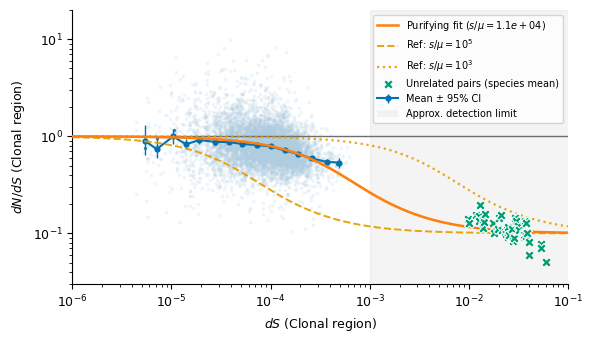

In [ ]:
import matplotlib as mpl
from matplotlib.patches import Patch
import dNdS_analysis.utils.figure_utils as figure_utils

# --- Colorblind-safe palette (Okabe–Ito) ---
COLORS = {
    "cloud":   figure_utils.clonal_color,
    "trend":   "#0072B2",  # deep blue
    "fit":     'tab:orange',
    "fit_ci":  'tab:orange',
    "fit_hi": "#E69F00",   # orange (Okabe–Ito)
    "fit_lo": "#E69F00",   # medium gray
    "species": "#009E73",  # bluish green
    "three":   "#CC79A7",  # reddish purple
    "neutral": "#6E6E6E",
    "shade":   "#AAAAAA",
}

# --- Ax + base styling ---
fig, ax = plt.subplots(figsize=(6, 3.5))
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# scatter cloud (thin + subtle)
sns.scatterplot(
    data=pair_scatter, x="dS_A", y="R_pair",
    s=6, linewidth=0, alpha=0.20, rasterized=True,
    legend=False, ax=ax, color=COLORS["cloud"], zorder=1
)

# mean ± CI per bin (stronger line, small caps)
ax.errorbar(
    x[valid], y[valid],
    yerr=[yerr_lo[valid], yerr_hi[valid]],
    fmt="-o", lw=1.5, ms=4.5, mew=0.0,
    color=COLORS["trend"], ecolor=COLORS["trend"],
    elinewidth=1.0, capsize=2.5, capthick=1.0,
    zorder=4, label="Mean ± 95% CI"
)

# single-sample ratio-of-totals (faint reference)
ax.plot(
    agg0["dS_x"], agg0["R_hat"],
    ".", ms=3, alpha=0.7, color=COLORS["trend"], zorder=3
)

# fitted 1-class curve + (optional) param ribbon
sb_central = ci_med if "ci_med" in locals() and np.isfinite(ci_med) else sb_hat
dS_grid = np.geomspace(1e-6, 1e-1, 400)

y_fit = dNdS_purify_curve(dS_grid, fd=FD_FIXED, sbymu=sb_central)
ax.plot(
    dS_grid, y_fit, lw=1.8, color=COLORS["fit"],
    label=fr"Purifying fit ($s/\mu={sb_central:.2g}$)", zorder=6
)
COLORS.update({
})

# reference curves (drop right after plotting the central red fit)
y_hi = dNdS_purify_curve(dS_grid, fd=FD_FIXED, sbymu=1e5)
ax.plot(dS_grid, y_hi, ls="--", lw=1.4, color=COLORS["fit_hi"],
        label=r"Ref: $s/\mu=10^5$", zorder=5, alpha=0.95)

y_lo = dNdS_purify_curve(dS_grid, fd=FD_FIXED, sbymu=1e3)
ax.plot(dS_grid, y_lo, ls=":", lw=1.6, color=COLORS["fit_lo"],
        label=r"Ref: $s/\mu=10^3$", zorder=5, alpha=0.9)

if ("ci_lo" in locals() and "ci_hi" in locals()
    and np.isfinite(ci_lo) and np.isfinite(ci_hi)):
    y_lo = dNdS_purify_curve(dS_grid, fd=FD_FIXED, sbymu=ci_lo)
    y_hi = dNdS_purify_curve(dS_grid, fd=FD_FIXED, sbymu=ci_hi)
    ax.fill_between(dS_grid, y_lo, y_hi, color=COLORS["fit_ci"], alpha=0.15, zorder=5)

# species-wise points (distinct marker with outline)
ax.scatter(
    species_dnds["dS_x"], species_dnds["R_hat"],
    marker="X", s=50, linewidths=0.8,
    edgecolors="white", color=COLORS["species"],
    label="Unrelated pairs (species mean)", zorder=7
)

# shaded region (put legend handle manually to avoid duplicate labels)
ax.axvspan(1e-3, 1, color=COLORS["shade"], alpha=0.12, zorder=0)
shade_handle = Patch(facecolor=COLORS["shade"], alpha=0.12, label="Approx. detection limit")

# axes, labels, neutrals
ax.set_xlim([1e-6, 1e-1])
ax.set_ylim([0.3e-1, 2e1])
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel(r"$dS$ (Clonal region)")
ax.set_ylabel(r"$dN/dS$ (Clonal region)")
ax.axhline(1, color=COLORS["neutral"], linestyle="-", lw=1.0, zorder=2)

# legend (dedupe + nice layout)
handles, labels = ax.get_legend_handles_labels()
handles.append(shade_handle); labels.append("Approx. detection limit")
ax.legend(handles, labels, frameon=True, loc="upper right", ncol=1, handlelength=2.2, fontsize=7)

plt.tight_layout()
plt.savefig(config.fig_path / "clonal_dNdS_purifying_fit.pdf", dpi=600, bbox_inches='tight')

In [9]:
x, y

(array([5.43871318e-06, 7.10280409e-06, 1.03959609e-05, 1.39879980e-05,
        1.91326881e-05, 2.75518346e-05, 3.80059515e-05, 5.19678795e-05,
        7.25645658e-05, 1.00214531e-04, 1.38508723e-04, 1.89111129e-04,
        2.59077040e-04, 3.68731341e-04, 4.92806573e-04]),
 array([0.89222292, 0.73786358, 0.99692069, 0.82776788, 0.91455504,
        0.87458491, 0.87096796, 0.8339844 , 0.81237012, 0.78640428,
        0.71582903, 0.65676715, 0.59274838, 0.54426959, 0.53684123]))

# Testing a three-class purifying selection model

$\alpha_1$ is the fraction of weakly selected sites, $\alpha_2$ is the fraction of strongly selected sites, and $\alpha_0$ is the fraction of neutral sites. The sum of these fractions equals 1.

We use the previously inferred $s/\mu$ for the weakly selected sites, and assume a $s/\mu$ a few orders of magnitude larger for the strongly selected sites. Under these assumptions, the only free parameter is the fraction of weakly selected sites, $\alpha_1$.

Inferred results show that under these assumptions, $\alpha_1$ is close to 0.9, showing no evidence for the existence of much stronger selection.

In [10]:
# ----------------------------------------------
# Three-class model: fit only alpha1
# ----------------------------------------------
# pick sbymu used for the weak/strong classes
sb_hat = 1e4
BEST_SBMU = ci_med if 'ci_med' in locals() and np.isfinite(ci_med) else sb_hat

ALPHA0 = 0.10 # fraction of neutral sites
SBMU1  = BEST_SBMU          # weakly deleterious s/μ
SBMU2  = BEST_SBMU * 1e3    # strongly deleterious s/μ

def dNdS_purify_curve_three_class(dS, alpha1,
                                  alpha0=ALPHA0,
                                  sbymu1=SBMU1,
                                  sbymu2=SBMU2):
    dS = np.asarray(dS, dtype=float)
    alpha2 = 1.0 - alpha0 - alpha1
    if (alpha1 < 0) or (alpha2 < 0):
        return np.full_like(dS, np.nan, dtype=float)
    x1 = sbymu1 * dS / 2.0
    x2 = sbymu2 * dS / 2.0
    # stable series near zero
    frac1 = np.where(x1 > 1e-12, (1.0 - np.exp(-x1)) / x1, 1.0 - x1/2.0 + x1**2/6.0)
    frac2 = np.where(x2 > 1e-12, (1.0 - np.exp(-x2)) / x2, 1.0 - x2/2.0 + x2**2/6.0)
    return alpha0 + alpha1*frac1 + (1.0 - alpha0 - alpha1)*frac2

from scipy.optimize import minimize_scalar

def fit_alpha1_wls(agg, alpha0=ALPHA0, sbymu1=SBMU1, sbymu2=SBMU2,
                   phi_N=1.0, phi_S=1.0, min_pairs=10):
    # same filtering as one-class
    m = (
        (agg['n_pairs'] >= min_pairs) &
        (agg['KN'] > 0) & (agg['KS_B'] > 0) &
        (agg['dS_x'] > 0) & (agg['R_hat'] > 0) &
        np.isfinite(agg['R_hat'].to_numpy(float))
    )
    if m.sum() < 3:
        return np.nan, np.nan, 0

    x  = agg.loc[m, 'dS_x' ].to_numpy(float)
    y  = agg.loc[m, 'R_hat'].to_numpy(float)
    KN = agg.loc[m, 'KN'   ].to_numpy(float)
    KS = agg.loc[m, 'KS_B' ].to_numpy(float)

    # inverse-variance weights on log-scale
    w = 1.0 / (phi_N/np.maximum(KN, 1.0) + phi_S/np.maximum(KS, 1.0))

    ub = max(1e-9, 1.0 - alpha0)  # ensure alpha2 >= 0
    def objective(alpha1):
        pred = dNdS_purify_curve_three_class(x, alpha1, alpha0, sbymu1, sbymu2)
        mask = np.isfinite(pred) & (pred > 0)
        if mask.sum() == 0:
            return np.inf
        resid = np.log(y[mask]) - np.log(pred[mask])
        return np.average(resid**2, weights=w[mask])

    res = minimize_scalar(objective, bounds=(0.0, ub), method='bounded')
    return res.x, res.fun, int(m.sum())

# --- point estimate on your current aggregation ---
alpha1_hat, loss3, used3 = fit_alpha1_wls(agg0, phi_N=phi_N, phi_S=phi_S, min_pairs=min_pairs)
alpha2_hat = 1.0 - ALPHA0 - alpha1_hat
print(f"Three-class fit: alpha1={alpha1_hat:.3g}, alpha2={alpha2_hat:.3g}  (bins used={used3}, loss={loss3:.3g})")

# --- bootstrap CI for alpha1 (resample pairs + re-thin + refit) ---
alpha1_samples = []
for _ in range(B):
    idx = rng.integers(0, len(counts_df), len(counts_df))
    boot_df = counts_df.iloc[idx].reset_index(drop=True)
    thin_b  = thin_counts(boot_df, p_thin, rng)
    agg_b   = aggregate_bins(thin_b, bin_edges)   # reuse fixed edges
    a1_b, _, _ = fit_alpha1_wls(agg_b, phi_N=phi_N, phi_S=phi_S, min_pairs=min_pairs)
    if np.isfinite(a1_b):
        alpha1_samples.append(a1_b)

alpha1_samples = np.asarray(alpha1_samples, dtype=float)
a1_lo, a1_med, a1_hi = (np.quantile(alpha1_samples, [0.025, 0.5, 0.975])
                        if alpha1_samples.size else (np.nan, np.nan, np.nan))
print(f"Bootstrap alpha1 CI: {a1_lo:.3g}, {a1_med:.3g}, {a1_hi:.3g}   (N={alpha1_samples.size})")

Three-class fit: alpha1=0.877, alpha2=0.023  (bins used=15, loss=0.00212)
Bootstrap alpha1 CI: 0.873, 0.883, 0.893   (N=600)


Scanning across more parameter combinations

In [11]:
def compute_loss_three_class(agg, alpha1, alpha0=ALPHA0,
                                  sbymu1=SBMU1, sbymu2=SBMU2,
                                  phi_N=1.0, phi_S=1.0, min_pairs=10):
    # same filtering as before
    m = (
        (agg['n_pairs'] >= min_pairs) &
        (agg['KN'] > 0) & (agg['KS_B'] > 0) &
        (agg['dS_x'] > 0) & (agg['R_hat'] > 0) &
        np.isfinite(agg['R_hat'].to_numpy(float))
    )
    if m.sum() < 3:
        return np.nan

    x  = agg.loc[m, 'dS_x' ].to_numpy(float)
    y  = agg.loc[m, 'R_hat'].to_numpy(float)
    KN = agg.loc[m, 'KN'   ].to_numpy(float)
    KS = agg.loc[m, 'KS_B' ].to_numpy(float)

    # inverse-variance weights on log-scale
    w = 1.0 / (phi_N/np.maximum(KN, 1.0) + phi_S/np.maximum(KS, 1.0))

    pred = dNdS_purify_curve_three_class(x, alpha1, alpha0, sbymu1, sbymu2)
    mask = np.isfinite(pred) & (pred > 0)
    if mask.sum() == 0:
        return np.inf
    resid = np.log(y[mask]) - np.log(pred[mask])
    return np.average(resid**2, weights=w[mask])

# prepare a grid of parameter combinations
# alpha2_grid = np.linspace(0.0, 1.0 - ALPHA0, 100)
alpha2_grid = np.geomspace(1e-2, 1.0 - ALPHA0, 100)
s2_grid = np.geomspace(1e3, 1e8, 100)
s1_grid = [1e3, 1e4, 1e5]
# s2_by_s1 = 1e2

loss_grid = np.full((len(alpha2_grid), len(s2_grid), len(s1_grid)), np.nan)
for i, alpha2 in enumerate(alpha2_grid):
    for j, s2 in enumerate(s2_grid):
        for k, s1 in enumerate(s1_grid):
            loss_grid[i, j, k] = compute_loss_three_class(
                agg0, 1 - ALPHA0 - alpha2, ALPHA0, sbymu1=s1, sbymu2=s2,
                phi_N=phi_N, phi_S=phi_S, min_pairs=min_pairs
            )

best_loss = loss_grid.min()
worst_loss = loss_grid.max()

0.04481404746557166


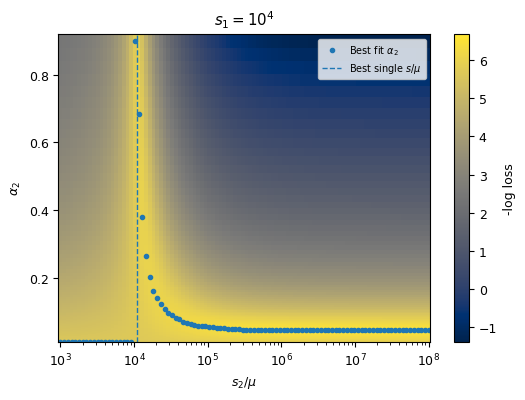

In [12]:
# plot the loss surface
fig, ax = plt.subplots(figsize=(6, 4))
loss_grid_plot = loss_grid[:, :, 1]
best_alpha2 = alpha2_grid[loss_grid_plot.argmin(axis=0)]
print(best_alpha2[-1])
X, Y = np.meshgrid(s2_grid, alpha2_grid, indexing='ij')
c = ax.pcolormesh(X, Y, -np.log(loss_grid_plot.T), shading='auto',
                    cmap='cividis', vmin=-np.log(worst_loss), vmax=-np.log(best_loss))
cbar = fig.colorbar(c, ax=ax)
cbar.set_label("-log loss")
ax.scatter(s2_grid, best_alpha2, label='Best fit $\\alpha_2$', marker='.')
ax.axvline(BEST_SBMU, linestyle='--', label='Best single $s/\mu$')
ax.legend(loc='upper right', frameon=True)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$s_2/\mu$')
ax.set_ylabel(r'$\alpha_2$')
ax.set_title(r'$s_1=10^4$')
fig.savefig(config.fig_path / 'purify_three_class_scan.pdf', bbox_inches='tight', dpi=600)

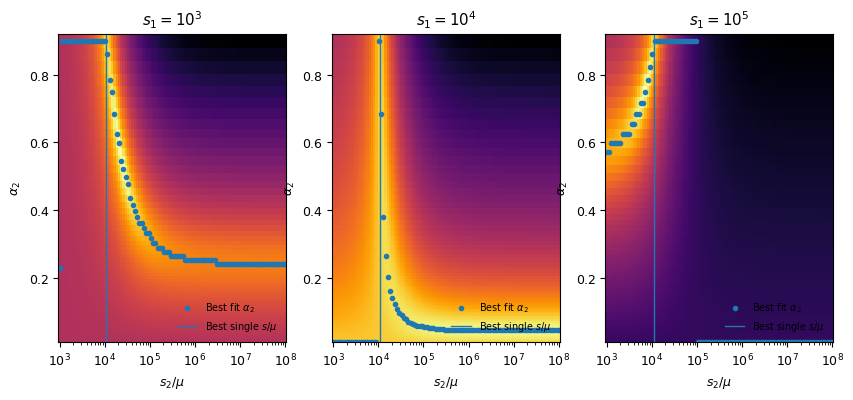

In [13]:
# Unused -- trying different s1 scans
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
s1_labels = [r'$s_1=10^3$', r'$s_1=10^4$', r'$s_1=10^5$']
for i, s1 in enumerate(s1_grid):
    loss_grid_plot = loss_grid[:, :, i]
    ax = axes[i]
    best_alpha2 = alpha2_grid[loss_grid_plot.argmin(axis=0)]
    X, Y = np.meshgrid(s2_grid, alpha2_grid, indexing='ij')
    c = ax.pcolormesh(X, Y, -np.log10(loss_grid_plot.T), shading='auto',
                        cmap='inferno', vmin=-np.log10(worst_loss), vmax=-np.log10(best_loss))
    ax.scatter(s2_grid, best_alpha2, label='Best fit $\\alpha_2$', marker='.')
    ax.axvline(BEST_SBMU, label='Best single $s/\mu$')
    ax.legend(loc='lower right')
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlabel(r'$s_2/\mu$')
    ax.set_ylabel(r'$\alpha_2$')
    ax.set_title(s1_labels[i])

# Separate dN/dS dynamics by missense and nonsense mutations

In this case, use the mutation opportunities (e.g. "clonal_m") and observed counts (e.g. "clonal_mut_m") for each mutation type, and repeat the same procedure as above.

In [14]:
full_dnds_df.columns

Index(['core_diff', 'core_len', 'core_len_4D', 'core_len_1D', 'core_diff_4D',
       'core_diff_1D', 'recomb_len_4D', 'recomb_len_1D', 'recomb_diff_4D',
       'recomb_diff_1D', 'clonal_len_4D', 'clonal_len_1D', 'clonal_diff_4D',
       'clonal_diff_1D', 'clonal_n', 'clonal_m', 'clonal_nn', 'recomb_n',
       'recomb_m', 'recomb_nn', 'clonal_mut_n', 'clonal_mut_m',
       'clonal_mut_nn', 'recomb_mut_n', 'recomb_mut_m', 'recomb_mut_nn'],
      dtype='object')

In [15]:
full_dnds_df['clonal_m'].sum() / full_dnds_df['clonal_n'].sum()

20.365362076917183

In [16]:
# ---------------------------------------------------------------------
# Missense vs Nonsense trends (same thinning; separate nonsyn classes)
# ---------------------------------------------------------------------
S_OPPS_PER_4D_SITE = 3.0   # opportunities per 4D site
# Map each class to its kN (observed SNVs) and LN (opportunities) columns
mut_defs = {
    "missense": {"kN": "clonal_mut_m", "LN": "clonal_m"},
    "nonsense": {"kN": "clonal_mut_n", "LN": "clonal_n"},
}

# 1) Use ONE thinning of the synonymous sites for both classes
#    (this keeps x and denom aligned/comparable across classes)
syn_df = full_dnds_df[['clonal_diff_4D','clonal_len_4D']].copy()
syn_df.columns = ['kS','LS']
thin_base = thin_counts(syn_df, p_thin, rng)   # adds kS_A, kS_B, LS_A, LS_B, dS_A, dS_B

# Attach class-specific kN/LN to the thinned frame
for cls, cols in mut_defs.items():
    thin_base[f'kN_{cls}'] = full_dnds_df[cols['kN']].to_numpy()
    thin_base[f'LN_{cls}'] = full_dnds_df[cols['LN']].to_numpy()

# Bin edges fixed from this single thinning
bin_edges = make_bins(thin_base['dS_A'], n_bins)

def aggregate_bins_for_class(thin_df, bin_edges, kN_col, LN_col):
    """Aggregate with ratio-of-totals for a specific nonsynonymous class."""
    df = thin_df.copy()
    df['kN'] = df[kN_col]
    df['LN'] = df[LN_col]
    # keep pairs with valid exposures and positive denom component
    df = df[
        (df['dS_A'] > 0) &
        (df['LN'] > 0) &
        (df['LS_B'] > 0) &
        (df['kS_B'] > 0)
    ].copy()
    df['bin'] = pd.cut(df['dS_A'], bin_edges, labels=False, include_lowest=True)

    gb = df.groupby('bin', dropna=True)
    agg = gb.agg(
        KN      = ('kN',   'sum'),
        LN      = ('LN',   'sum'),
        KS_A    = ('kS_A', 'sum'),
        KS_B    = ('kS_B', 'sum'),
        LS_A    = ('LS_A', 'sum'),
        LS_B    = ('LS_B', 'sum'),
        n_pairs = ('kN',   'size'),
    ).reset_index()

    # pooled x and pooled ratio-of-totals
    agg['dS_x']  = safe_div_series(agg['KS_A'], agg['LS_A'])
    numer        = safe_div_series(agg['KN'],   agg['LN'])
    denom        = safe_div_series(agg['KS_B'], agg['LS_B']) / S_OPPS_PER_4D_SITE
    agg['R_hat'] = numer / denom

    m = (agg['dS_x'] > 0) & (agg['R_hat'] > 0) & np.isfinite(agg['R_hat'])
    return agg.loc[m].reset_index(drop=True)

# 2) Per-pair scatter for each class (same x and denom; different numerators)
pair_scatter_tidy = []
for cls in mut_defs:
    df = thin_base.copy()
    numer = safe_div_series(df[f'kN_{cls}'], df[f'LN_{cls}'])
    denom = safe_div_series(df['kS_B'],      df['LS_B']) / S_OPPS_PER_4D_SITE
    m = (
        (df['dS_A'] > 0) &
        (df[f'LN_{cls}'] > 0) &
        (df['LS_B'] > 0) &
        (df['kS_B'] > 0) &
        (denom > 0)
    )
    tmp = pd.DataFrame({
        'dS_A':  df.loc[m, 'dS_A'].values,
        'R_pair': (numer.loc[m].values / denom.loc[m].values),
        'mut_class': cls
    })
    tmp = tmp[(tmp['R_pair'] > 0) & np.isfinite(tmp['R_pair'])]
    pair_scatter_tidy.append(tmp)

pair_scatter_tidy = pd.concat(pair_scatter_tidy, ignore_index=True)

# 3) Point estimates per bin (no bootstrap yet)
agg0_by_class = {}
for cls in mut_defs:
    agg0 = aggregate_bins_for_class(thin_base, bin_edges, f'kN_{cls}', f'LN_{cls}').astype(float)
    agg0['mut_class'] = cls
    agg0_by_class[cls] = agg0

# 4) Bootstrap (resample pairs + re-thin) to get CIs for each class
logR_by_class = {cls: np.full((B, n_bins), np.nan) for cls in mut_defs}

n_pairs_total = len(full_dnds_df)
for b in range(B):
    idx = rng.integers(0, n_pairs_total, n_pairs_total)

    # re-thin synonymous side on the resample
    syn_boot = syn_df.iloc[idx].reset_index(drop=True)
    thin_b   = thin_counts(syn_boot, p_thin, rng)

    # attach bootstrapped class-specific counts
    for cls, cols in mut_defs.items():
        thin_b[f'kN_{cls}'] = full_dnds_df[cols['kN']].to_numpy()[idx]
        thin_b[f'LN_{cls}'] = full_dnds_df[cols['LN']].to_numpy()[idx]

        agg_b = aggregate_bins_for_class(thin_b, bin_edges, f'kN_{cls}', f'LN_{cls}').astype(float)
        if not agg_b.empty:
            bins_present = agg_b['bin'].astype(int).values
            logR_by_class[cls][b, bins_present] = np.log(agg_b['R_hat'].values)

# 5) Assemble median and 95% CI per class into a tidy frame for plotting
plot_df_list = []
for cls in mut_defs:
    agg0 = agg0_by_class[cls]
    if agg0.empty:
        continue
    bins_present = agg0['bin'].astype(int).values
    q_lo  = np.nanpercentile(logR_by_class[cls],  2.5, axis=0)
    q_med = np.nanpercentile(logR_by_class[cls], 50.0, axis=0)
    q_hi  = np.nanpercentile(logR_by_class[cls], 97.5, axis=0)

    y_med_all = np.exp(q_med)
    y_lo_all  = np.exp(q_lo)
    y_hi_all  = np.exp(q_hi)

    x = agg0['dS_x'].to_numpy()
    y = y_med_all[bins_present]
    yerr_lo = np.clip(y - y_lo_all[bins_present], 0, None)
    yerr_hi = np.clip(y_hi_all[bins_present] - y, 0, None)

    valid = np.isfinite(x) & np.isfinite(y) & np.isfinite(yerr_lo) & np.isfinite(yerr_hi)
    plot_df_list.append(pd.DataFrame({
        'mut_class': cls,
        'dS_x': x[valid],
        'R_med': y[valid],
        'R_lo':  (y[valid] - yerr_lo[valid]),
        'R_hi':  (y[valid] + yerr_hi[valid]),
        'n_pairs': agg0.loc[valid, 'n_pairs'].to_numpy(),
        'bin': agg0.loc[valid, 'bin'].astype(int).to_numpy(),
    }))

plot_df = pd.concat(plot_df_list, ignore_index=True)



In [17]:
# -----------------------------------------------------------
# Species-wise dN/dS from unrelated pairs (missense & nonsense)
# Reuses: thin_counts(), make_bins(), safe_div_series()
# -----------------------------------------------------------

S_OPPS_PER_4D_SITE = 3.0
species_col = 'species_name'   # <-- change if needed

typical_dnds_df = dynamics_utils.load_typical_pair_dNdS_data().reset_index(drop=False)

# Flexible rename to standardize column names; keep whatever applies in your table.
rename_map = {
    # synonymous
    'core_diff_4D':   'kS',  'core_len_4D':   'LS',

    # missense
    'core_mut_m':     'kN_miss', 'core_m':     'LN_miss',

    # nonsense
    'core_mut_n':     'kN_nons', 'core_n':     'LN_nons',
}
typ_counts = typical_dnds_df.copy()
for k, v in list(rename_map.items()):
    if k in typ_counts.columns and v not in typ_counts.columns:
        typ_counts = typ_counts.rename(columns={k: v})

needed = {species_col, 'kS','LS','kN_miss','LN_miss','kN_nons','LN_nons'}
missing = needed - set(typ_counts.columns)
if missing:
    raise ValueError(f"typical_dnds_df missing columns: {missing}")

def aggregate_bins_for_class_opp(thin_df, bin_edges, kN_col, LN_col):
    """
    Ratio-of-totals for one mut class with per-opportunity denom:
      R_hat = (sum kN / sum LN) / ((sum kS_B / sum LS_B) / 3)
    dS_x is pooled per-site (KS_A/LS_A), matching earlier plots.
    """
    df = thin_df.copy()
    df['kN'] = df[kN_col]
    df['LN'] = df[LN_col]

    # filters to keep denom defined/positive
    m = (
        (df['dS_A'] > 0) &
        (df['LN'] > 0) &
        (df['LS_B'] > 0) &
        (df['kS_B'] > 0)
    )
    df = df.loc[m].copy()
    if df.empty:
        return pd.DataFrame()

    df['bin'] = pd.cut(df['dS_A'], bin_edges, labels=False, include_lowest=True)

    gb = df.groupby('bin', dropna=True)
    agg = gb.agg(
        KN      = ('kN',   'sum'),
        LN      = ('LN',   'sum'),
        KS_A    = ('kS_A', 'sum'),
        KS_B    = ('kS_B', 'sum'),
        LS_A    = ('LS_A', 'sum'),
        LS_B    = ('LS_B', 'sum'),
        n_pairs = ('kN',   'size'),
    ).reset_index()

    # pooled x (per-site) and ratio-of-totals with per-opportunity denom
    dS_x   = safe_div_series(agg['KS_A'], agg['LS_A'])                   # per-site
    numer  = safe_div_series(agg['KN'],   agg['LN'])                     # per-opportunity on nonsyn
    denom  = safe_div_series(agg['KS_B'], agg['LS_B']) / S_OPPS_PER_4D_SITE  # per-opportunity on syn
    R_hat  = numer / denom

    out = agg.copy()
    out['dS_x']  = dS_x
    out['R_hat'] = R_hat
    m2 = (out['dS_x'] > 0) & (out['R_hat'] > 0) & np.isfinite(out['R_hat'])
    return out.loc[m2].reset_index(drop=True)

records = []
for sp, df_sp in typ_counts.groupby(species_col, sort=False):
    if df_sp.empty:
        continue

    # Thin synonymous side once for this species
    syn_only = df_sp[['kS','LS']].copy()
    th = thin_counts(syn_only, p_thin, rng)

    # Attach class-specific counts (no thinning on nonsyn side)
    th['kN_miss'] = df_sp['kN_miss'].to_numpy()
    th['LN_miss'] = df_sp['LN_miss'].to_numpy()
    th['kN_nons'] = df_sp['kN_nons'].to_numpy()
    th['LN_nons'] = df_sp['LN_nons'].to_numpy()

    # Single bin per species (unrelated-pair pooling)
    dSpos = th['dS_A'][th['dS_A'] > 0]
    if dSpos.empty:
        continue
    edges = make_bins(th['dS_A'], n_bins=1)

    for mut_class, kN_col, LN_col in [
        ('missense', 'kN_miss', 'LN_miss'),
        ('nonsense', 'kN_nons', 'LN_nons'),
    ]:
        agg_sp = aggregate_bins_for_class_opp(th, edges, kN_col, LN_col)
        if agg_sp.empty:
            continue
        row = agg_sp.iloc[0]
        records.append({
            species_col: sp,
            'mut_class': mut_class,
            'dS_x':   float(row['dS_x']),     # per-site pooled dS on split A
            'R_hat':  float(row['R_hat']),    # per-opportunity ratio-of-totals
            'KN':     int(row['KN']),
            'KS_B':   int(row['KS_B']),
            'LN':     float(row['LN']),
            'LS_B':   float(row['LS_B']),
            'n_pairs': int(row['n_pairs']),
        })

species_dnds_tidy = pd.DataFrame.from_records(records).sort_values(['mut_class','dS_x']).reset_index(drop=True)
species_dnds_tidy.head()


,species_name,mut_class,dS_x,R_hat,KN,KS_B,LN,LS_B,n_pairs
0,Bacteroides_caccae_53434,missense,0.009803,0.148258,57255,44664,117735423.0,4538874.0,20
1,Bacteroides_massiliensis_44749,missense,0.009913,0.132154,37557,32313,84816501.0,3214583.5,20
2,Odoribacter_splanchnicus_62174,missense,0.011695,0.161222,57265,41485,90628077.0,3528314.0,20
3,Alistipes_sp_60764,missense,0.012577,0.154681,40814,36861,63063802.0,2936670.5,20
4,Bacteroides_fragilis_54507,missense,0.012710,0.139922,70089,59445,118301435.0,4679714.0,20


In [18]:
# -----------------------------------------------------------
# Fit purifying model per class
# -----------------------------------------------------------

S_OPPS_PER_4D_SITE = 3.0  # already used in aggregate_bins_for_class_opp

# ----- 1) Fix f_d per class from unrelated pairs (ratio-of-totals across species)
FD_BY_CLASS = {}
for cls in ('missense', 'nonsense'):
    dfc = species_dnds_tidy[species_dnds_tidy['mut_class'] == cls]
    if dfc.empty:
        FD_BY_CLASS[cls] = np.nan
        continue
    KN_sum  = dfc['KN'  ].sum()
    LN_sum  = dfc['LN'  ].sum()
    KS_sum  = dfc['KS_B'].sum()
    LS_sum  = dfc['LS_B'].sum()
    R_eq = ( (KN_sum / max(LN_sum, 1.0)) /
            ( (KS_sum / max(LS_sum, 1.0)) / S_OPPS_PER_4D_SITE ) )
    FD_BY_CLASS[cls] = float(np.clip(1.0 - R_eq, 0.0, 0.999999))
print("Fixed f_d by class:", FD_BY_CLASS)

# ----- 2) Prepare one thinning (point estimate) + shared bins
# (Rebuild minimally in case thin_base/bin_edges not in scope)
syn_df = full_dnds_df[['clonal_diff_4D','clonal_len_4D']].copy()
syn_df.columns = ['kS','LS']
thin_base = thin_counts(syn_df, p_thin, rng)
thin_base['kN_miss'] = full_dnds_df['clonal_mut_m'].to_numpy()
thin_base['LN_miss'] = full_dnds_df['clonal_m'   ].to_numpy()
thin_base['kN_nons'] = full_dnds_df['clonal_mut_n'].to_numpy()
thin_base['LN_nons'] = full_dnds_df['clonal_n'   ].to_numpy()

bin_edges = make_bins(thin_base['dS_A'], n_bins)

# Small wrapper to get agg (with counts) for a class
def agg_for_class(thin_df, kN_col, LN_col):
    return aggregate_bins_for_class_opp(thin_df, bin_edges, kN_col, LN_col).astype(float)

# ----- 3) Fit s/μ per class + bootstrap CI
fit_results = {}  # cls -> dict with sb_hat, ci_lo, ci_med, ci_hi

for cls, kN_col, LN_col in [('missense','kN_miss','LN_miss'),
                            ('nonsense','kN_nons','LN_nons')]:
    fd_fixed = FD_BY_CLASS.get(cls, np.nan)
    if not np.isfinite(fd_fixed):
        fit_results[cls] = dict(sb_hat=np.nan, ci_lo=np.nan, ci_med=np.nan, ci_hi=np.nan)
        continue

    # point estimate
    agg0_cls = agg_for_class(thin_base, kN_col, LN_col)
    sb_hat, loss0, used0 = fit_sbymu_wls(agg0_cls, fd=fd_fixed,
                                         phi_N=phi_N, phi_S=phi_S,
                                         min_pairs=min_pairs)
    # bootstrap
    sb_samples = []
    n_pairs = len(full_dnds_df)
    for _ in range(B):
        idx = rng.integers(0, n_pairs, n_pairs)
        # re-thin on resample
        syn_boot = syn_df.iloc[idx].reset_index(drop=True)
        thin_b   = thin_counts(syn_boot, p_thin, rng)
        # attach class counts for the resample
        thin_b['kN_miss'] = full_dnds_df['clonal_mut_m'].to_numpy()[idx]
        thin_b['LN_miss'] = full_dnds_df['clonal_m'   ].to_numpy()[idx]
        thin_b['kN_nons'] = full_dnds_df['clonal_mut_n'].to_numpy()[idx]
        thin_b['LN_nons'] = full_dnds_df['clonal_n'   ].to_numpy()[idx]

        agg_b = agg_for_class(thin_b, kN_col, LN_col)
        sb_b, _, _ = fit_sbymu_wls(agg_b, fd=fd_fixed,
                                   phi_N=phi_N, phi_S=phi_S,
                                   min_pairs=min_pairs)
        if np.isfinite(sb_b):
            sb_samples.append(sb_b)

    sb_samples = np.asarray(sb_samples, float)
    if sb_samples.size:
        ci_lo, ci_med, ci_hi = np.quantile(sb_samples, [0.025, 0.5, 0.975])
    else:
        ci_lo = ci_med = ci_hi = np.nan

    fit_results[cls] = dict(sb_hat=sb_hat, ci_lo=ci_lo, ci_med=ci_med, ci_hi=ci_hi)
    print(f"[{cls}] f_d={fd_fixed:.3g}  s/μ={sb_hat:.3g}  CI: {ci_lo:.3g}, {ci_med:.3g}, {ci_hi:.3g}")

Fixed f_d by class: {'missense': 0.8870694183902713, 'nonsense': 0.9915984977696872}
[missense] f_d=0.887  s/μ=1e+04  CI: 9.85e+03, 1.02e+04, 1.06e+04
[nonsense] f_d=0.992  s/μ=5.21e+04  CI: 5.02e+04, 5.24e+04, 5.44e+04


Comparing a two-class fit with a one-class fit for nonsense mutations.

In [19]:
from scipy.optimize import minimize_scalar

S_OPPS_PER_4D_SITE = 3.0
S2_BY_MU_FIXED = 1e7      # "very strong" class
DS_THRESH = 3e-5          # early regime cutoff
EPS = 1e-30

# --- fallback: fd per class from species_dnds_tidy, if needed ---
if 'FD_BY_CLASS' not in globals():
    FD_BY_CLASS = {}
    for cls in ('missense','nonsense'):
        dfc = species_dnds_tidy[species_dnds_tidy['mut_class']==cls]
        KN, LN = dfc['KN'].sum(), dfc['LN'].sum()
        KS, LS = dfc['KS_B'].sum(), dfc['LS_B'].sum()
        R_eq = ( (KN/max(LN,1.0)) / ((KS/max(LS,1.0))/S_OPPS_PER_4D_SITE) )
        FD_BY_CLASS[cls] = float(np.clip(1.0 - R_eq, 0.0, 0.999999))
print("Fixed f_d:", FD_BY_CLASS)

def F_small(x):
    return (1.0 - np.exp(-x)) / np.clip(x, EPS, None)

def dnds_two_class(dS, fd, alpha2, s1mu, s2mu=S2_BY_MU_FIXED):
    alpha2 = np.clip(alpha2, 0.0, fd)
    alpha1 = fd - alpha2
    return (1.0 - fd) + alpha1 * F_small(0.5*s1mu*dS) + alpha2 * F_small(0.5*s2mu*dS)

def estimate_alpha2_from_early(thin_df, kN_col, LN_col, ds_thresh=DS_THRESH):
    """Ratio-of-totals R_low on dS_A<thresh, then alpha2 = 1 - R_low."""
    df = thin_df.copy()
    m = (
        (df['dS_A'] > 0) & (df['dS_A'] < ds_thresh) &
        (df['LS_B'] > 0) & (df['kS_B'] > 0) &
        (df[LN_col] > 0)
    )
    if not np.any(m):
        return np.nan, 0, np.nan   # alpha2, n_pairs, mean_dS
    KN = df.loc[m, kN_col].sum()
    LN = df.loc[m, LN_col].sum()
    KS = df.loc[m, 'kS_B'].sum()
    LS = df.loc[m, 'LS_B'].sum()
    if LN <= 0 or LS <= 0 or KS <= 0:
        return np.nan, int(m.sum()), np.nan
    R_low = ( (KN/LN) / ((KS/LS)/S_OPPS_PER_4D_SITE) )
    return float(np.clip(1.0 - R_low, 0.0, 1.0)), int(m.sum()), float(df.loc[m, 'dS_A'].mean())

def fit_s1_given_alpha2(agg, fd, alpha2, bounds=(1e-3, 1e7),
                        phi_N=1.0, phi_S=1.0, min_pairs=10):
    """1D WLS fit for s1/mu with fixed alpha2 (and large s2/mu)."""
    m = (
        (agg['n_pairs'] >= min_pairs) &
        (agg['KN'] > 0) & (agg['KS_B'] > 0) &
        (agg['dS_x'] > 0) & (agg['R_hat'] > 0) &
        np.isfinite(agg['R_hat'].to_numpy(float))
    )
    if m.sum() < 3 or not np.isfinite(alpha2) or not np.isfinite(fd):
        return np.nan, np.nan, 0

    x  = agg.loc[m, 'dS_x' ].to_numpy(float)
    y  = agg.loc[m, 'R_hat'].to_numpy(float)
    KN = agg.loc[m, 'KN'   ].to_numpy(float)
    KS = agg.loc[m, 'KS_B' ].to_numpy(float)
    w  = 1.0 / (phi_N/np.maximum(KN,1.0) + phi_S/np.maximum(KS,1.0))

    def objective(s1mu):
        pred = dnds_two_class(x, fd, alpha2, s1mu, s2mu=S2_BY_MU_FIXED)
        resid = np.log(y) - np.log(pred)
        return np.average(resid**2, weights=w)

    res = minimize_scalar(objective, bounds=bounds, method='bounded')
    return float(res.x), float(res.fun), int(m.sum())

# --- Point estimate on nonsense: alpha2 from early, then fit s1/mu ---
fd_nons = FD_BY_CLASS['nonsense']
# make sure we have a thinned frame with nonsense counts attached
if 'thin_base' not in globals():
    syn_df = full_dnds_df[['clonal_diff_4D','clonal_len_4D']].copy()
    syn_df.columns = ['kS','LS']
    thin_base = thin_counts(syn_df, p_thin, rng)
    thin_base['kN_nons'] = full_dnds_df['clonal_mut_n'].to_numpy()
    thin_base['LN_nons'] = full_dnds_df['clonal_n'   ].to_numpy()

if 'bin_edges' not in globals():
    bin_edges = make_bins(thin_base['dS_A'], n_bins)

alpha2_hat, early_n, dS_mean_early = estimate_alpha2_from_early(
    thin_base, 'kN_nons', 'LN_nons', ds_thresh=DS_THRESH
)
print(f"[nonsense alpha2] early pairs={early_n}, alpha2~{alpha2_hat:.3g}, mean dS={dS_mean_early:.2e}")

agg0_nons = aggregate_bins_for_class_opp(thin_base, bin_edges, 'kN_nons', 'LN_nons').astype(float)
s1_hat, loss0, used0 = fit_s1_given_alpha2(
    agg0_nons, fd=fd_nons, alpha2=alpha2_hat,
    phi_N=phi_N, phi_S=phi_S, min_pairs=min_pairs
)
print(f"[nonsense s1/mu] s1/mu={s1_hat:.3g}, bins used={used0}, loss={loss0:.3g}")

# --- Optional small-x correction for alpha2 (1 iteration) ---
# Using R_low ≈ 1 - alpha2 - (fd - alpha2) * (s1/mu) * <dS> / 4
if np.isfinite(s1_hat) and np.isfinite(dS_mean_early):
    C = max(0.0, (s1_hat * dS_mean_early) / 4.0)
    R_low = 1.0 - alpha2_hat
    denom = max(1e-9, 1.0 - C)
    alpha2_corr = (1.0 - C*fd_nons - R_low) / denom
    alpha2_corr = float(np.clip(alpha2_corr, 0.0, fd_nons))
    if np.isfinite(alpha2_corr):
        alpha2_hat = alpha2_corr
        # refit s1 with corrected alpha2
        s1_hat, loss0, used0 = fit_s1_given_alpha2(
            agg0_nons, fd=fd_nons, alpha2=alpha2_hat,
            phi_N=phi_N, phi_S=phi_S, min_pairs=min_pairs
        )
        print(f"[nonsense alpha2 corrected] alpha2={alpha2_hat:.3g}; refit s1/mu={s1_hat:.3g}")

# --- Bootstrap (re-estimate alpha2 in each replicate) ---
a2_samps, s1_samps = [], []
n_pairs = len(full_dnds_df)
for _ in range(B):
    idx = rng.integers(0, n_pairs, n_pairs)
    syn_b = syn_df.iloc[idx].reset_index(drop=True)
    th_b  = thin_counts(syn_b, p_thin, rng)
    th_b['kN_nons'] = full_dnds_df['clonal_mut_n'].to_numpy()[idx]
    th_b['LN_nons'] = full_dnds_df['clonal_n'   ].to_numpy()[idx]

    a2_b, _, _ = estimate_alpha2_from_early(th_b, 'kN_nons', 'LN_nons', ds_thresh=DS_THRESH)
    agg_b = aggregate_bins_for_class_opp(th_b, bin_edges, 'kN_nons', 'LN_nons').astype(float)
    s1_b, _, used_b = fit_s1_given_alpha2(agg_b, fd=fd_nons, alpha2=a2_b,
                                          phi_N=phi_N, phi_S=phi_S, min_pairs=min_pairs)
    if np.isfinite(a2_b) and np.isfinite(s1_b) and used_b >= 3:
        a2_samps.append(a2_b); s1_samps.append(s1_b)

a2_samps = np.asarray(a2_samps, float)
s1_samps = np.asarray(s1_samps, float)
if a2_samps.size and s1_samps.size:
    a2_lo, a2_med, a2_hi = np.quantile(a2_samps, [0.025, 0.5, 0.975])
    s1_lo, s1_med, s1_hi = np.quantile(s1_samps, [0.025, 0.5, 0.975])
else:
    a2_lo = a2_med = a2_hi = s1_lo = s1_med = s1_hi = np.nan

print(f"[nonsense 2-class EARLY-FIX] alpha2={alpha2_hat:.3g} "
      f"(CI {a2_lo:.3g},{a2_med:.3g},{a2_hi:.3g}); "
      f"s1/mu={s1_hat:.3g} (CI {s1_lo:.3g},{s1_med:.3g},{s1_hi:.3g}); "
      f"N={a2_samps.size}")




Fixed f_d: {'missense': 0.8870694183902713, 'nonsense': 0.9915984977696872}
[nonsense alpha2] early pairs=609, alpha2~0.431, mean dS=1.99e-05
[nonsense s1/mu] s1/mu=2.1e+04, bins used=15, loss=0.0277
[nonsense alpha2 corrected] alpha2=0.365; refit s1/mu=2.58e+04
[nonsense 2-class EARLY-FIX] alpha2=0.365 (CI 0.403,0.453,0.492); s1/mu=2.58e+04 (CI 1.66e+04,1.96e+04,2.34e+04); N=600


/var/folders/hg/9rp27v5d51d0948tcdf8mkk80000gq/T/ipykernel_80185/910553513.py:34: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/hg/9rp27v5d51d0948tcdf8mkk80000gq/T/ipykernel_80185/910553513.py:34: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(


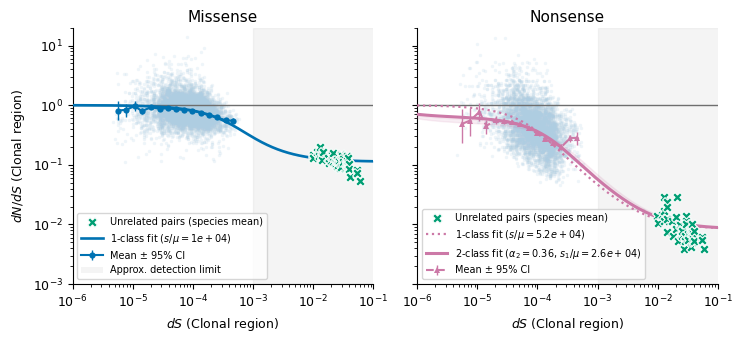

In [20]:
# -----------------------------------------------------------
# Two-panel plot with 1-class (missense & nonsense) + 2-class (nonsense)
# Reuses: species_dnds_tidy, fit_results, FD_BY_CLASS,
#         dNdS_purify_curve, dnds_two_class, alpha2_hat, s1_hat,
#         a2_lo, a2_hi, s1_lo, s1_hi, S2_BY_MU_FIXED, COLORS
# -----------------------------------------------------------
from matplotlib.patches import Patch

# ---------------- Colors (Okabe–Ito + your theme) ----------------
COLORS = {
    "cloud":   figure_utils.clonal_color,  # faint per-pair
    "trend_miss": "#0072B2",               # deep blue
    "trend_nons": "#CC79A7",               # reddish purple
    "species": "#009E73",                  # bluish green
    "neutral": "#6E6E6E",
    "shade":   "#AAAAAA",
}

# ---------------- Small helpers ----------------
def plot_panel(ax, cls, trend_color, marker, linestyle):
    # 1) per-pair scatter (thin + subtle)
    df_sc = pair_scatter_tidy[pair_scatter_tidy["mut_class"] == cls]
    if not df_sc.empty:
        sns.scatterplot(
            data=df_sc, x="dS_A", y="R_pair",
            s=6, linewidth=0, alpha=0.20, rasterized=True,
            legend=False, ax=ax, color=COLORS["cloud"], zorder=1
        )

    # 2) binned median ± 95% CI (ratio-of-totals)
    df_tr = plot_df[plot_df["mut_class"] == cls].sort_values("dS_x")
    if not df_tr.empty:
        yerr = np.vstack([df_tr["R_med"] - df_tr["R_lo"], df_tr["R_hi"] - df_tr["R_med"]])
        ax.errorbar(
            df_tr["dS_x"], df_tr["R_med"], yerr=yerr,
            fmt=marker, lw=1.5, ms=4.5, mew=0.0,
            color=trend_color, ecolor=trend_color,
            elinewidth=1.0, capsize=2.5, capthick=1.0,
            zorder=4, label="Mean ± 95% CI", linestyle=linestyle
        )
        # optional faint single-sample ratio-of-totals points
        ax.plot(df_tr["dS_x"], df_tr["R_med"], ".", ms=3, alpha=0.7,
                color=trend_color, zorder=3)

    # 3) species-wise means (unrelated pairs)
    if "species_dnds_tidy" in globals():
        df_sp = species_dnds_tidy[species_dnds_tidy["mut_class"] == cls]
        if not df_sp.empty:
            ax.scatter(
                df_sp["dS_x"], df_sp["R_hat"],
                marker="X", s=50, linewidths=0.8,
                edgecolors="white", color=COLORS["species"],
                label="Unrelated pairs (species mean)", zorder=7
            )

    # Ax cosmetics
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlim([1e-6, 1e-1])
    ax.set_ylim([1e-3, 2e1])  # 0.0004 to 20
    ax.axhline(1, color=COLORS["neutral"], linestyle="-", lw=1.0, zorder=2)

def add_fit(ax, xg, y_c, y_lo=None, y_hi=None, *, color, ls, lw=1.8, label=None, band_alpha=0.12, z=6):
    ax.plot(xg, y_c, color=color, ls=ls, lw=lw, label=label, zorder=z)
    if (y_lo is not None) and (y_hi is not None) and np.all(np.isfinite([y_lo, y_hi])):
        ax.fill_between(xg, y_lo, y_hi, color=color, alpha=band_alpha, zorder=z-1)

FIT_STYLES = {
    "miss_1c": dict(color=COLORS["trend_miss"], ls="-",   lw=1.9, band_alpha=0.12),
    "nons_1c": dict(color=COLORS["trend_nons"], ls=":",   lw=1.6, band_alpha=0.08),
    "nons_2c": dict(color=COLORS["trend_nons"], ls="-",   lw=2.2, band_alpha=0.12),
}

fig, axes = plt.subplots(1, 2, figsize=(7.5, 3.5), sharex=True, sharey=True)

# Panels (scatter + binned means + species means)
plot_panel(axes[0], "missense",  COLORS["trend_miss"], marker="-o", linestyle="-")
plot_panel(axes[1], "nonsense",  COLORS["trend_nons"], marker="^-", linestyle="--")

# Shaded detection band
axes[0].axvspan(1e-3, 1, color=COLORS["shade"], alpha=0.12, zorder=0)
axes[1].axvspan(1e-3, 1, color=COLORS["shade"], alpha=0.12, zorder=0)
shade_handle = Patch(facecolor=COLORS["shade"], alpha=0.12, label="Approx. detection limit")

# Fits
dS_grid = np.geomspace(1e-6, 1e-1, 400)

# --- Missense: 1-class fit + ribbon ---
res = fit_results.get('missense', {})
fd  = FD_BY_CLASS['missense']
if np.isfinite(res.get('sb_hat', np.nan)):
    y_c  = dNdS_purify_curve(dS_grid, fd, res['sb_hat'])
    y_lo = dNdS_purify_curve(dS_grid, fd, res['ci_lo']) if np.isfinite(res.get('ci_lo', np.nan)) else None
    y_hi = dNdS_purify_curve(dS_grid, fd, res['ci_hi']) if np.isfinite(res.get('ci_hi', np.nan)) else None
    add_fit(axes[0], dS_grid, y_c, y_lo, y_hi,
            **FIT_STYLES["miss_1c"],
            label=fr"1-class fit ($s/\mu={res['sb_hat']:.2g}$)")

# --- Nonsense: 1-class fit (dotted, no ribbon to reduce clutter) ---
res = fit_results.get('nonsense', {})
fd  = FD_BY_CLASS['nonsense']
if np.isfinite(res.get('sb_hat', np.nan)):
    y_c = dNdS_purify_curve(dS_grid, fd, res['sb_hat'])
    add_fit(axes[1], dS_grid, y_c, None, None,
            **FIT_STYLES["nons_1c"],
            label=fr"1-class fit ($s/\mu={res['sb_hat']:.2g}$)")

# --- Nonsense: 2-class fit (solid + ribbon) ---
if np.isfinite(alpha2_hat) and np.isfinite(s1_hat):
    y_c  = dnds_two_class(dS_grid, fd, alpha2_hat, s1_hat, s2mu=S2_BY_MU_FIXED)
    y_lo = (dnds_two_class(dS_grid, fd, a2_hi, s1_lo, s2mu=S2_BY_MU_FIXED)
            if np.all(np.isfinite([a2_hi, s1_lo])) else None)
    y_hi = (dnds_two_class(dS_grid, fd, a2_lo, s1_hi, s2mu=S2_BY_MU_FIXED)
            if np.all(np.isfinite([a2_lo, s1_hi])) else None)
    add_fit(axes[1], dS_grid, y_c, y_lo, y_hi,
            **FIT_STYLES["nons_2c"],
            label=fr"2-class fit ($\alpha_2={alpha2_hat:.2f}$, $s_1/\mu={s1_hat:.2g}$)")

# Labels & titles
axes[0].set_xlabel(r"$dS$ (Clonal region)")
axes[1].set_xlabel(r"$dS$ (Clonal region)")
axes[0].set_ylabel(r"$dN/dS$ (Clonal region)")
axes[0].set_title("Missense", fontsize=11, pad=4)
axes[1].set_title("Nonsense", fontsize=11, pad=4)

# Tidy legends
# Left panel: include shaded band handle
h0, l0 = axes[0].get_legend_handles_labels()
h0.append(shade_handle); l0.append("Approx. detection limit")
axes[0].legend(h0, l0, frameon=True, loc="lower left", ncol=1, handlelength=2.2, fontsize=7)

# Right panel: just whatever is present
h1, l1 = axes[1].get_legend_handles_labels()
axes[1].legend(h1, l1, frameon=True, loc="lower left", ncol=1, handlelength=2.2, fontsize=7)

plt.tight_layout()
plt.savefig(config.fig_path / "clonal_dNdS_missense_nonsense_panels_with_fits.pdf",
            dpi=600, bbox_inches='tight')


Evaluating the improvements in the fit by comparing the two-class and one-class models.

In [21]:
# -----------------------------------------------------------
# Compare 1-class vs 2-class fits (nonsense)
# Reuses: agg0_nons, fit_results['nonsense'], FD_BY_CLASS['nonsense'],
#         dNdS_purify_curve, dnds_two_class, alpha2_hat, s1_hat,
#         a2_samps, s1_samps, syn_df, p_thin, rng, B, min_pairs, phi_N, phi_S,
#         aggregate_bins_for_class_opp, thin_counts, S2_BY_MU_FIXED, DS_THRESH
# -----------------------------------------------------------
def _mask_bins(agg, min_pairs=10):
    return (
        (agg['n_pairs'] >= min_pairs) &
        (agg['KN'] > 0) & (agg['KS_B'] > 0) &
        (agg['dS_x'] > 0) & (agg['R_hat'] > 0) &
        np.isfinite(agg['R_hat'].to_numpy(float))
    )

def _wls_metrics(agg, pred, k_params=1, phi_N=1.0, phi_S=1.0):
    """Return dict of metrics for y=R_hat vs pred on log scale."""
    m = _mask_bins(agg, min_pairs)
    x  = agg.loc[m, 'dS_x' ].to_numpy(float)
    y  = agg.loc[m, 'R_hat'].to_numpy(float)
    KN = agg.loc[m, 'KN'   ].to_numpy(float)
    KS = agg.loc[m, 'KS_B' ].to_numpy(float)

    # safety
    pred = np.asarray(pred, float)
    pred = pred[:len(x)]
    r = np.log(y) - np.log(pred)

    w = 1.0 / (phi_N/np.maximum(KN,1.0) + phi_S/np.maximum(KS,1.0))
    wMSE = np.average(r**2, weights=w)                    # your objective
    SSE  = np.sum(r**2)                                   # unweighted SSE (for AIC/BIC)
    n    = r.size
    k    = int(k_params)

    # AIC/BIC on log-residuals (approximate, for comparison only)
    AIC  = n * np.log(SSE / max(n,1)) + 2*k  if n>k else np.nan
    BIC  = n * np.log(SSE / max(n,1)) + k*np.log(max(n,1)) if n>k else np.nan

    return {
        'n_bins': n,
        'wMSE': wMSE,
        'RMSE_log': float(np.sqrt(np.mean(r**2))),
        'AIC': float(AIC), 'BIC': float(BIC)
    }

# --- Point-estimate metrics on the original nonsense aggregate ---
fd_n  = FD_BY_CLASS['nonsense']
m_pt  = _mask_bins(agg0_nons, min_pairs)
x_pt  = agg0_nons.loc[m_pt, 'dS_x'].to_numpy(float)

# 1-class pred
sb1   = fit_results['nonsense']['sb_hat']
y1_pt = dNdS_purify_curve(x_pt, fd_n, sb1) if np.isfinite(sb1) else np.array([])

# 2-class pred (alpha2 fixed from early, s1_hat fitted)
y2_pt = dnds_two_class(x_pt, fd_n, alpha2_hat, s1_hat, s2mu=S2_BY_MU_FIXED) \
        if (np.isfinite(alpha2_hat) and np.isfinite(s1_hat)) else np.array([])

# choose parameter counts (alpha2 fixed -> k=1 for both)
k_1c, k_2c = 1, 1     # set k_2c=2 if you *fit* alpha2 instead of fixing it

m1 = _wls_metrics(agg0_nons, y1_pt, k_params=k_1c, phi_N=phi_N, phi_S=phi_S)
m2 = _wls_metrics(agg0_nons, y2_pt, k_params=k_2c, phi_N=phi_N, phi_S=phi_S)

print("[Nonsense | point] 1-class:",
      f"wMSE={m1['wMSE']:.4g}, RMSE_log={m1['RMSE_log']:.4g}, AIC={m1['AIC']:.2f}, BIC={m1['BIC']:.2f}, n={m1['n_bins']}")
print("[Nonsense | point] 2-class:",
      f"wMSE={m2['wMSE']:.4g}, RMSE_log={m2['RMSE_log']:.4g}, AIC={m2['AIC']:.2f}, BIC={m2['BIC']:.2f}, n={m2['n_bins']}")
print("Δ (1c−2c):",
      f"ΔwMSE={m1['wMSE']-m2['wMSE']:.4g}, ΔAIC={m1['AIC']-m2['AIC']:.2f}, ΔBIC={m1['BIC']-m2['BIC']:.2f}")

# --- Bootstrap Δ-loss to quantify improvement robustness (same resamples used earlier pattern) ---
delta_wMSE = []
improved   = 0
n_pairs    = len(full_dnds_df)

for _ in range(B):
    idx = rng.integers(0, n_pairs, n_pairs)

    # re-thin synonymous + attach nonsense counts
    syn_b = syn_df.iloc[idx].reset_index(drop=True)
    th_b  = thin_counts(syn_b, p_thin, rng)
    th_b['kN_nons'] = full_dnds_df['clonal_mut_n'].to_numpy()[idx]
    th_b['LN_nons'] = full_dnds_df['clonal_n'   ].to_numpy()[idx]

    # early alpha2 per replicate (fixed from early data):
    a2_b, _, _ = estimate_alpha2_from_early(th_b, 'kN_nons', 'LN_nons', ds_thresh=DS_THRESH)

    # aggregate bins on this replicate
    agg_b = aggregate_bins_for_class_opp(th_b, bin_edges, 'kN_nons', 'LN_nons').astype(float)
    if _mask_bins(agg_b, min_pairs).sum() < 3 or not np.isfinite(a2_b):
        continue

    # fit 1-class on replicate
    sb1_b, _, _ = fit_sbymu_wls(agg_b, fd=fd_n, phi_N=phi_N, phi_S=phi_S, min_pairs=min_pairs)
    if not np.isfinite(sb1_b):
        continue

    # fit 2-class on replicate (s1|a2_b)
    s1_b, _, _ = fit_s1_given_alpha2(agg_b, fd=fd_n, alpha2= a2_b,
                                     phi_N=phi_N, phi_S=phi_S, min_pairs=min_pairs)
    if not np.isfinite(s1_b):
        continue

    # predictions on replicate bins
    m_b   = _mask_bins(agg_b, min_pairs)
    x_b   = agg_b.loc[m_b, 'dS_x'].to_numpy(float)
    y1_b  = dNdS_purify_curve(x_b, fd_n, sb1_b)
    y2_b  = dnds_two_class(x_b, fd_n, a2_b, s1_b, s2mu=S2_BY_MU_FIXED)

    # compute weighted log-MSE for each
    m1_b = _wls_metrics(agg_b, y1_b, k_params=k_1c, phi_N=phi_N, phi_S=phi_S)
    m2_b = _wls_metrics(agg_b, y2_b, k_params=k_2c, phi_N=phi_N, phi_S=phi_S)

    d = m1_b['wMSE'] - m2_b['wMSE']
    delta_wMSE.append(d)
    improved += (d > 0)

delta_wMSE = np.asarray(delta_wMSE, float)
if delta_wMSE.size:
    d_lo, d_med, d_hi = np.quantile(delta_wMSE, [0.025, 0.5, 0.975])
    frac_better = improved / delta_wMSE.size
    print(f"[Bootstrap ΔwMSE] median={d_med:.4g}  95% CI=({d_lo:.4g}, {d_hi:.4g})  "
          f"improved in {frac_better:.1%} of replicates (N={delta_wMSE.size})")
else:
    print("[Bootstrap ΔwMSE] insufficient replicates to summarize.")


[Nonsense | point] 1-class: wMSE=0.05767, RMSE_log=0.4703, AIC=-20.63, BIC=-19.92, n=15
[Nonsense | point] 2-class: wMSE=0.02895, RMSE_log=0.3303, AIC=-31.24, BIC=-30.53, n=15
Δ (1c−2c): ΔwMSE=0.02871, ΔAIC=10.61, ΔBIC=10.61
[Bootstrap ΔwMSE] median=0.02923  95% CI=(0.01894, 0.04146)  improved in 100.0% of replicates (N=600)


# Plot per species dN/dS dynamics

In [22]:
import per_species_dnds
import per_species_plotting

from importlib import reload
reload(per_species_dnds)
reload(per_species_plotting)

<module 'per_species_plotting' from '/Users/Device6/Documents/Research/bgoodlab/dNdS/dNdS_dynamics/dNdS_analysis/plotting_scripts/per_species_plotting.py'>

In [23]:
full_dnds_df = dynamics_utils.load_dNdS_data()

In [24]:
from per_species_dnds import ThinSettings, compute_all_species
from per_species_plotting import plot_species_grid_styled  # your styled grid

settings = ThinSettings(
    auto_bins=True,
    target_pairs_per_bin=50,
    min_pairs_per_bin=20,
    min_bins=4,
    max_bins=20,
    min_bins_retained=3,
    binning_strategy="geom",   # or "quantile"
    B=400,
    p_thin=0.5,
    rng_seed=42,
    min_pairs_per_species=10
)

results = compute_all_species(full_dnds_df, settings=settings, species_col="species_name",
                              classes=("all","missense","nonsense"))




/Users/Device6/Documents/Research/bgoodlab/dNdS/dNdS_dynamics/dNdS_analysis/plotting_scripts/per_species_dnds.py:315: RuntimeWarning: divide by zero encountered in divide
  R_pair = numer / denom
/Users/Device6/Documents/Research/bgoodlab/dNdS/dNdS_dynamics/dNdS_analysis/plotting_scripts/per_species_dnds.py:315: RuntimeWarning: divide by zero encountered in divide
  R_pair = numer / denom
/Users/Device6/Documents/Research/bgoodlab/dNdS/dNdS_dynamics/dNdS_analysis/plotting_scripts/per_species_dnds.py:315: RuntimeWarning: invalid value encountered in divide
  R_pair = numer / denom
/Users/Device6/miniforge3/envs/dNdS_310/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/Device6/miniforge3/envs/dNdS_310/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/Device6/miniforge3/envs/dNdS_310/lib/python3.10/si

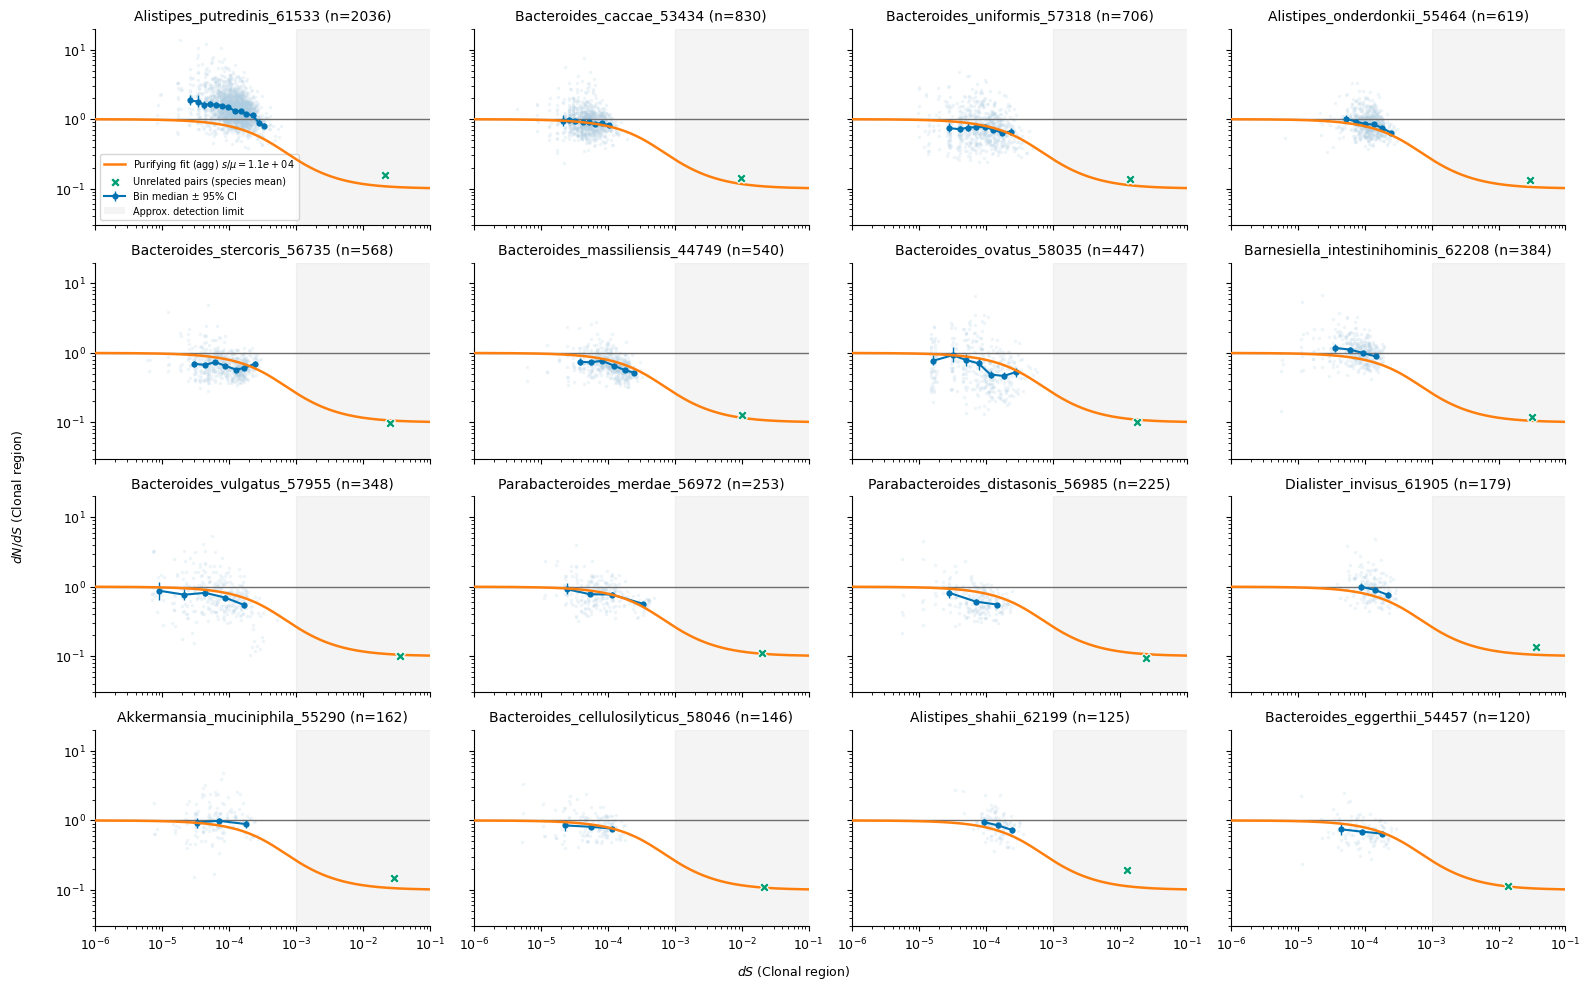

In [25]:
from per_species_plotting import plot_species_grid_styled

COLORS = {
    "cloud":   figure_utils.clonal_color,
    "trend":   "#0072B2",   # deep blue
    "trend_nons": "#CC79A7",  # reddish purple
    "fit":     'tab:orange',  # (unused here; no fit curve)
    "fit_ci":  'tab:orange',  # (unused here)
    "fit_hi":  "#E69F00",     # (unused here)
    "fit_lo":  "#E69F00",     # (unused here)
    "species": "#009E73",   # cross color
    "three":   "#CC79A7",   # (unused here)
    "neutral": "#6E6E6E",
    "shade":   "#AAAAAA",
}

purify = {
    "curve_fn": dNdS_purify_curve,
    "kwargs":   {"fd": FD_FIXED, "sbymu": sb_central},
    # Optional: custom grid (defaults to np.geomspace(xlim[0], xlim[1], 400))
    # "x": np.geomspace(1e-6, 1e-1, 400),
    "label": rf"Purifying fit (agg) $s/\mu={sb_central:.2g}$",
}

results_sorted = dict(sorted(results.items(), key=lambda kv: kv[1].n_pairs, reverse=True))

fig, axes = plot_species_grid_styled(
    results_sorted, which_class="all",
    COLORS=COLORS,
    species_dnds_tidy=species_dnds,
    species_col="species_name", x_col="dS_x", y_col="R_hat",
    legend_mode="first", ncols=4,
    xlim=(1e-6, 1e-1), ylim=(0.03, 20.0),
    purify=purify,
)

fig.savefig(config.fig_path / "clonal_dNdS_species_grid_all.pdf",
            dpi=600, bbox_inches='tight')

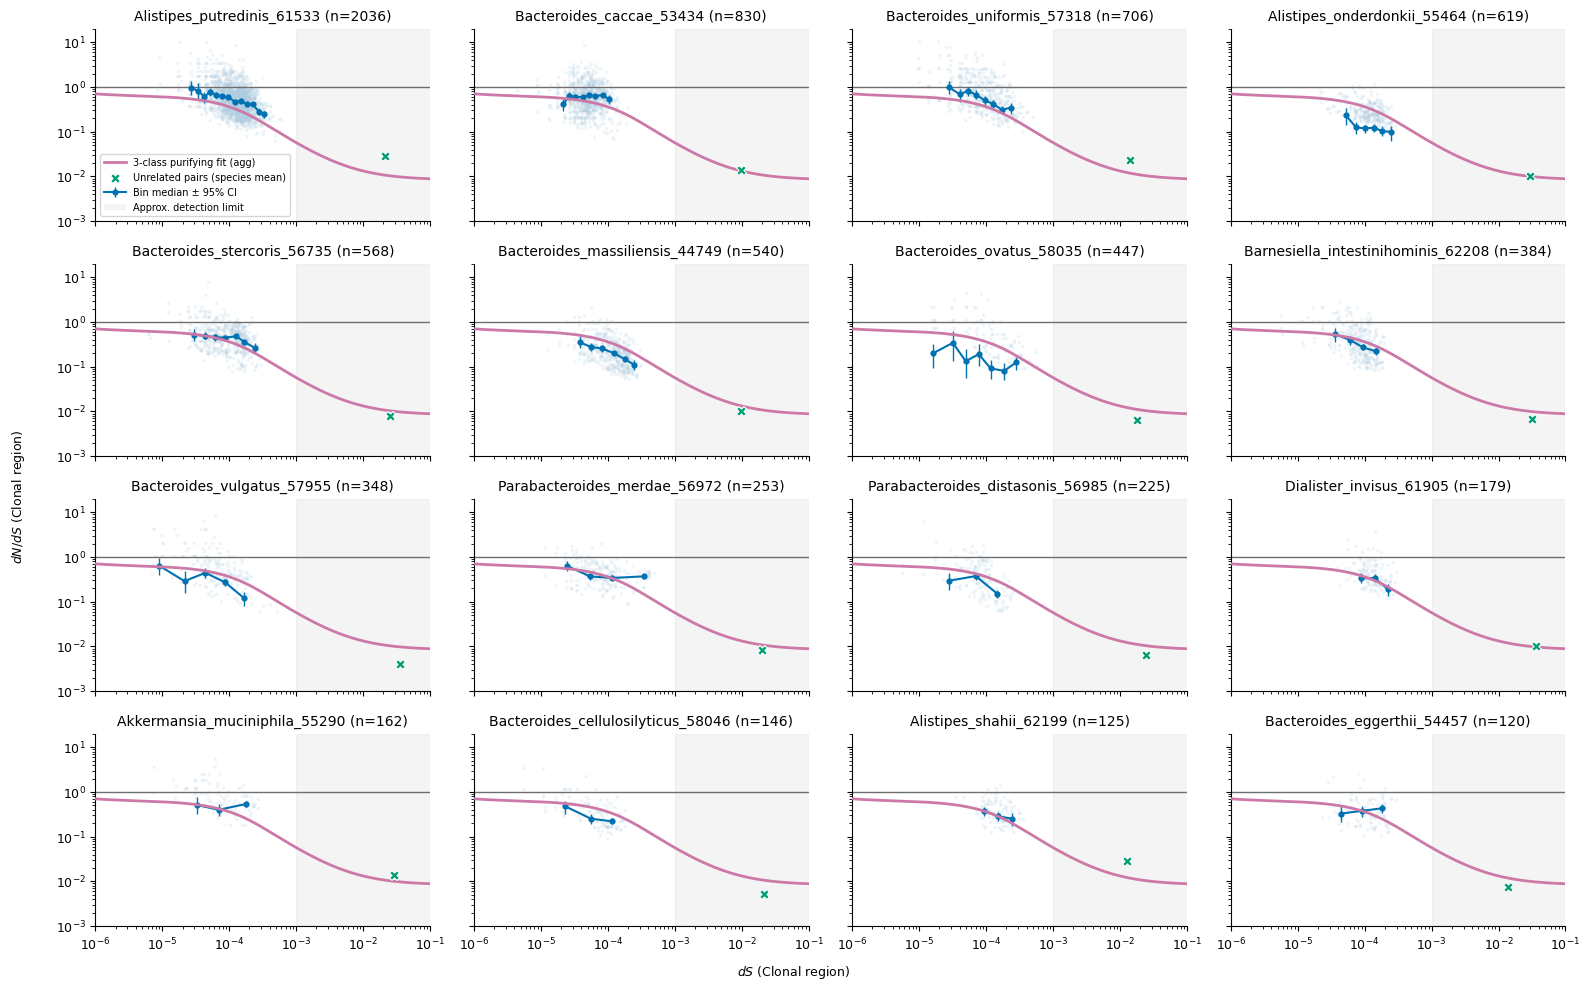

In [26]:
purify = [
  # Combined 3-class + CI ribbon by calling curve_fn with lo/hi params
  {"curve_fn": dnds_two_class,
   "kwargs": {
       "fd": FD_BY_CLASS['nonsense'],
       "alpha2": alpha2_hat, "s1mu": s1_hat, "s2mu": S2_BY_MU_FIXED
   },
   "label": "3-class purifying fit (agg)", "color": COLORS.get("trend_nons"), "lw": 2.0},
]

fig, axes = plot_species_grid_styled(
    results, species_col='species_name', which_class="nonsense",
    COLORS=COLORS, species_dnds_tidy=species_dnds_tidy[species_dnds_tidy['mut_class']=='nonsense'],
    purify=purify, legend_mode="first", ncols=4, ylim=(1e-3, 20.0)
)
fig.savefig(config.fig_path / "clonal_dNdS_species_grid_nonsense.pdf",
            dpi=600, bbox_inches='tight')


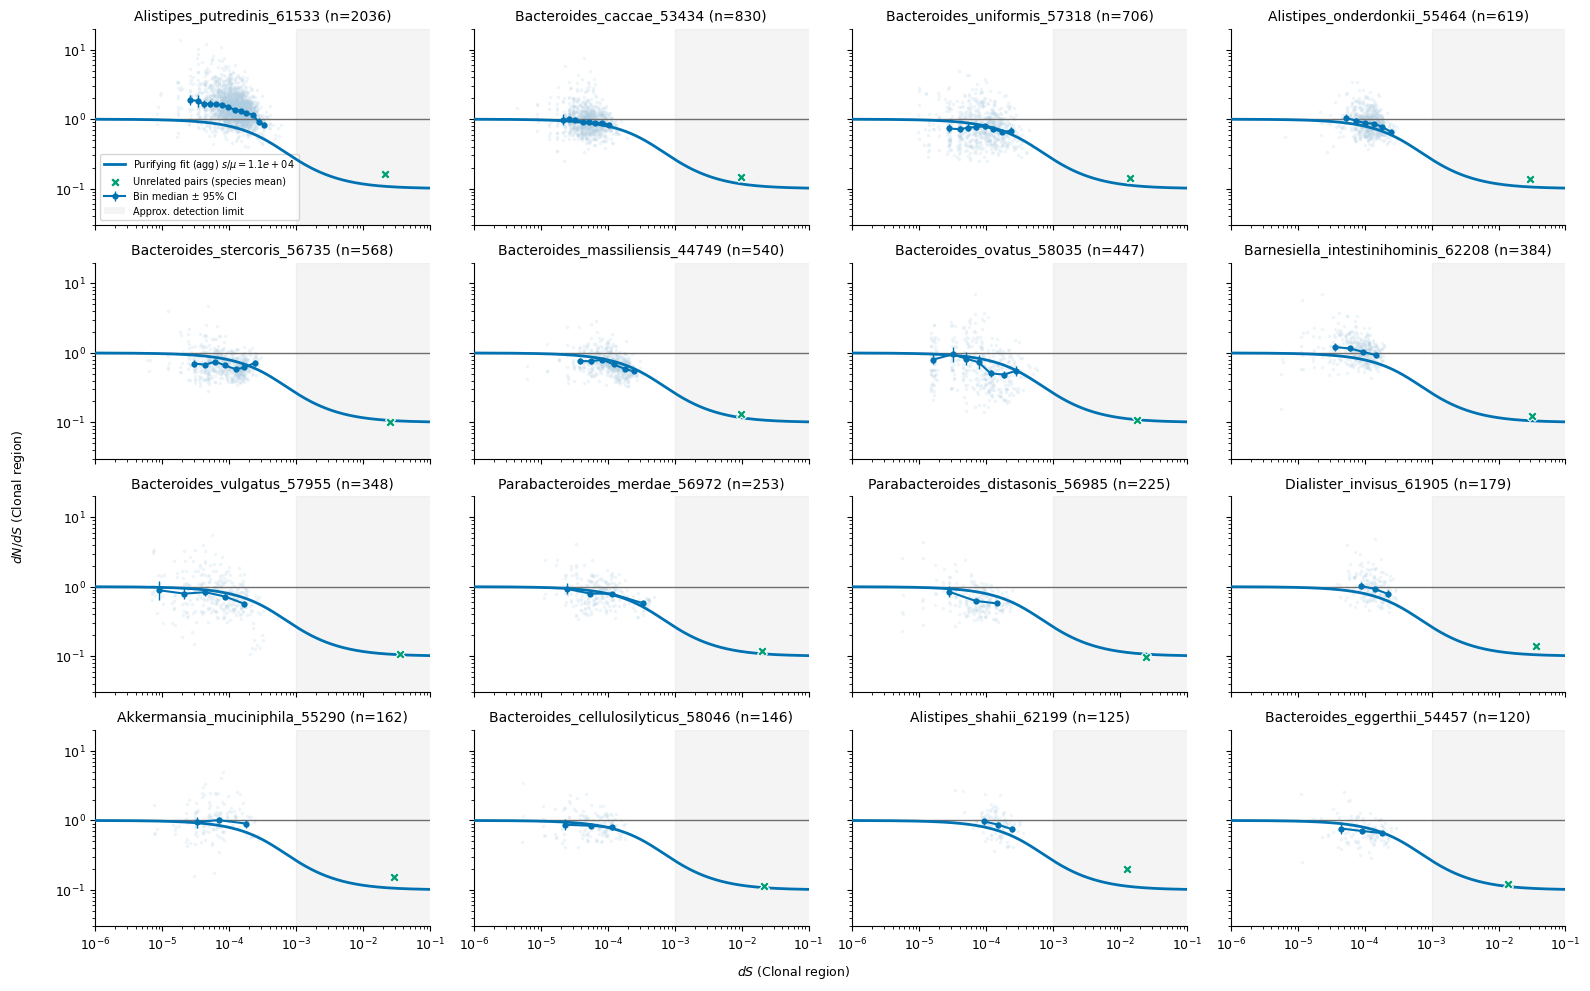

In [27]:
purify = {
    "curve_fn": dNdS_purify_curve,
    "kwargs":   {"fd": FD_FIXED, "sbymu": sb_central},
    "label": rf"Purifying fit (agg) $s/\mu={sb_central:.2g}$", "color": COLORS.get("trend"), "lw": 2.0
}

fig, axes = plot_species_grid_styled(
    results, species_col='species_name', which_class="missense",
    COLORS=COLORS, species_dnds_tidy=species_dnds_tidy[species_dnds_tidy['mut_class']=='missense'],
    purify=purify, legend_mode="first", ncols=4, 
)
fig.savefig(config.fig_path / "clonal_dNdS_species_grid_missense.pdf",
            dpi=600, bbox_inches='tight')
